In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as krs
import numpy
from keras.datasets import mnist
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, roc_curve, auc, accuracy_score
from scipy.cluster.vq import kmeans2
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


import tensorflow as tf
import keras
from keras import layers

import os
from google.colab import drive

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/sukhanich-lapochka')

Mounted at /content/drive


In [3]:
'''Here's I'm trying to build variational autouncoder like saysay said
Source code: https://keras.io/examples/generative/vae/'''

#building sampling layer

@keras.saving.register_keras_serializable()
class Sampling(layers.Layer):
    '''Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.'''

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [4]:
nw = 28
nh = 28
num_hide = 98
num_classes = 10

latent_dim = 2

#building encoder
encoder_inputs = keras.Input(shape=(nw, nh, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

#building decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [5]:
#Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name='reconstruction_loss'
        )
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

In [6]:
#trainning encoder
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = numpy.concatenate([x_train, x_test], axis=0)
mnist_digits = numpy.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

encoder.save('encoder_vae.keras')

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 12s 9ms/step - loss: 264.6797 - reconstruction_loss: 211.7402 - kl_loss: 2.8929
Epoch 2/30
547/547 [==============================] - 5s 8ms/step - loss: 189.3727 - reconstruction_loss: 184.3525 - kl_loss: 3.4783
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 184.7320 - reconstruction_loss: 180.2724 - kl_loss: 3.5528
Epoch 4/30
547/547 [==============================] - 4s 8ms/step - loss: 181.4299 - reconstruction_loss: 176.7728 - kl_loss: 3.8319
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 178.0681 - reconstruction_loss: 172.4887 - kl_loss: 4.5008
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 172.7450 - reconstruction_loss: 164.9518 - kl_loss: 5.3925
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 164.0107 - reconstruction_loss: 156.8892 - kl_loss: 6.2836
Epo

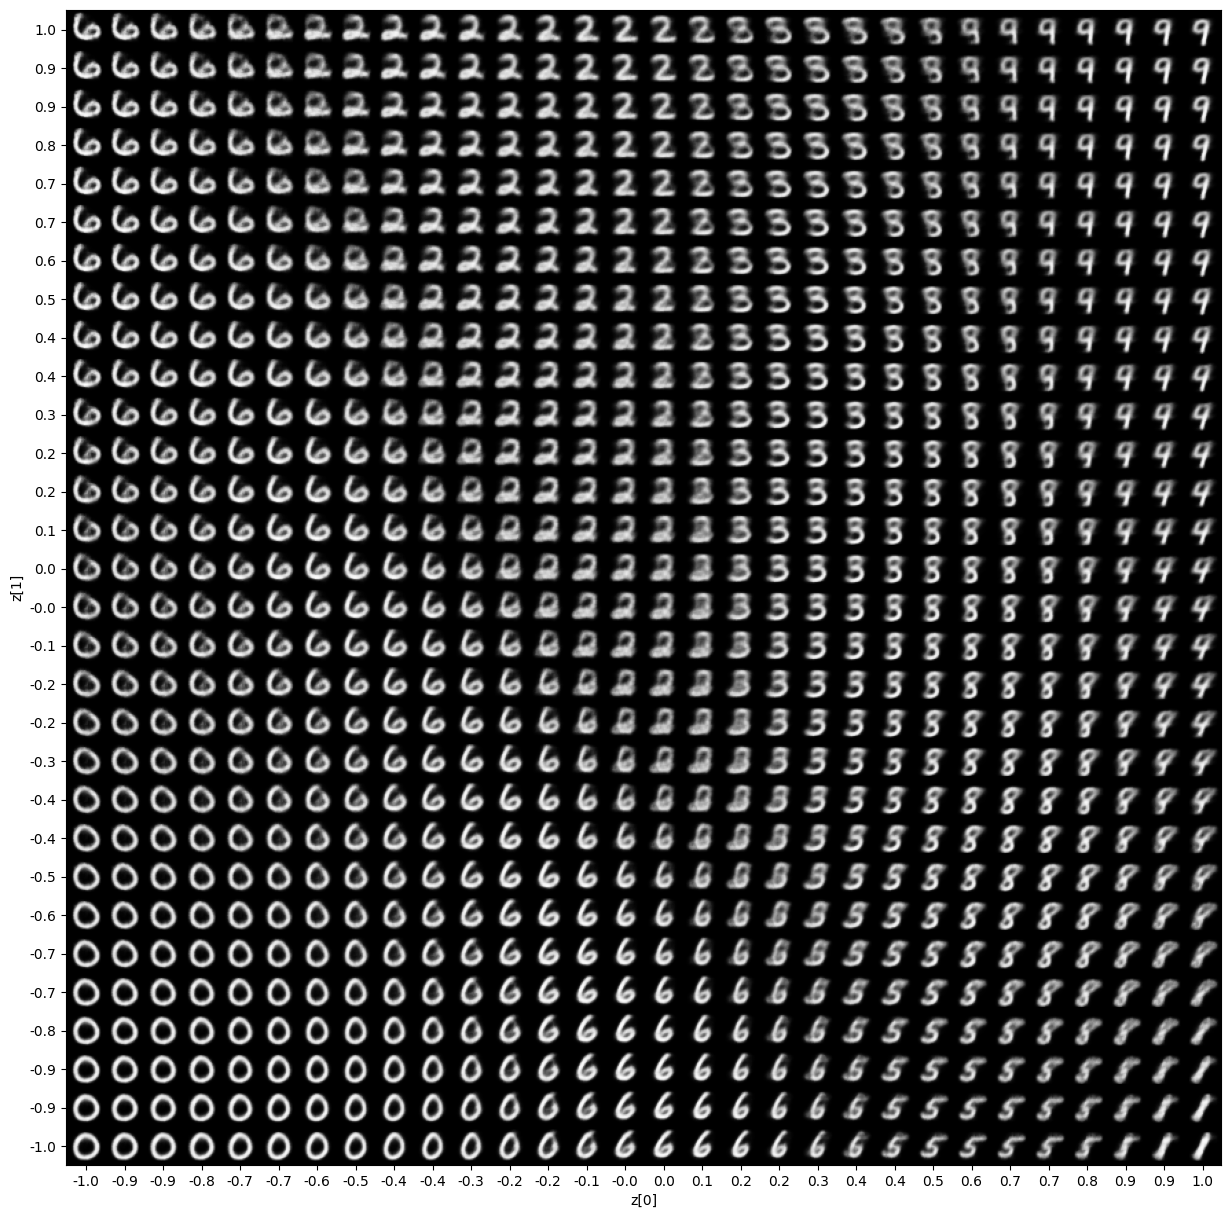

In [7]:
#Display a grid of sampled digits


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = numpy.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = numpy.linspace(-scale, scale, n)
    grid_y = numpy.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = numpy.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = numpy.arange(start_range, end_range, digit_size)
    sample_range_x = numpy.round(grid_x, 1)
    sample_range_y = numpy.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


plot_latent_space(vae)


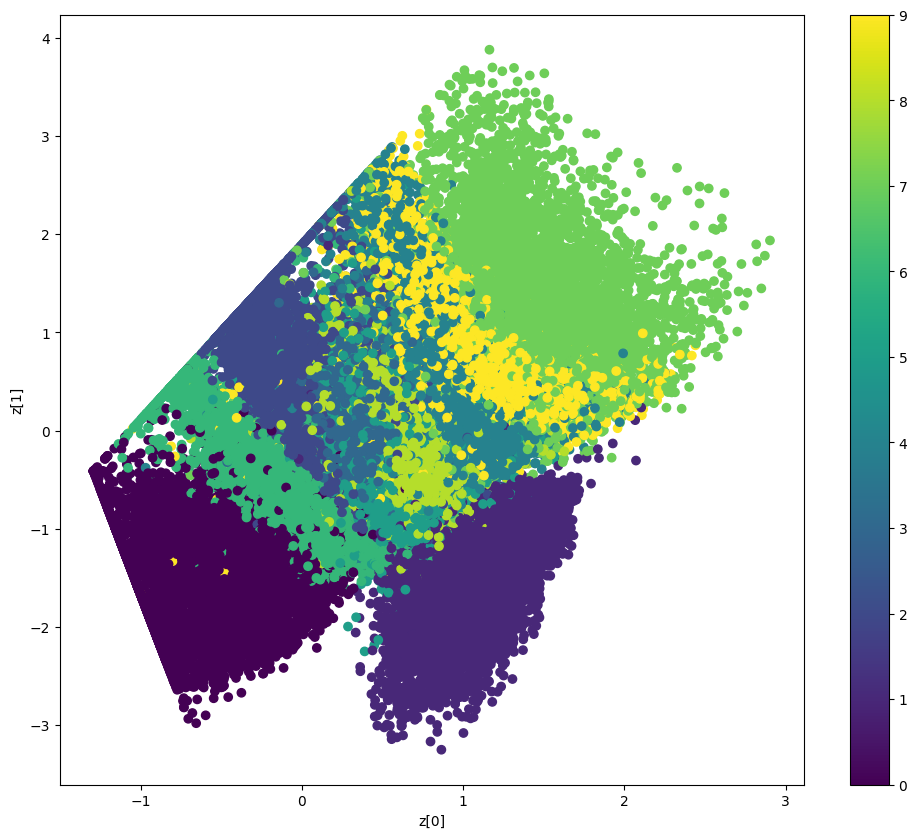

In [8]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = numpy.expand_dims(x_train, -1).astype('float32') / 255

plot_label_clusters(vae, x_train, y_train)

In [9]:
nw = 28
nh = 28
num_hide = 98
num_classes = 10
n_count = 32
Conv2D_count = (3, 3)

# загружаем примеры обучения mnist (рукописные цифры)
(trainx, trainy), (testx, testy) = mnist.load_data()
# нормируем от -1 до 1 изображения цифр
all_image = (trainx/255.0-0.5)*1.999
# добавляем дополнительное измерение соответствующее одной цветовой карте
all_image = numpy.expand_dims(all_image, axis=3)

# задаем входной слой экодера высота на ширину на количество карт
encoder_input = krs.layers.Input(shape=(nw,nh,1))
# задаем сверточный слой с 32 фильтрами-картами и фильтрами 3 на 3
# оставляет тот же размер карты 28*28
lay = krs.layers.Conv2D(n_count, Conv2D_count, strides = (2,2), activation='relu', padding='same')(encoder_input)
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 2, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
# добавляем слой прореживания
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 4, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
lay = krs.layers.Dropout(0.15)(lay)
lay = krs.layers.Conv2D(n_count * 8, Conv2D_count, strides = (2,2),activation='relu', padding='same')(lay)
# слой который многомерный тензорный слой превращает в плоский вектор
lay = krs.layers.Flatten()(lay)

# выходной кодирующий слой
lay_out_encoder = krs.layers.Dense(num_hide, activation='linear', name='den4')(lay)
# создаем сеть энкодера
encoder = krs.Model(encoder_input, lay_out_encoder)

# создание сети декодера, входной слой
decoder_input = krs.layers.Input(shape=(num_hide,))
lay = krs.layers.Dense(n_count * 4 * 7 * 7)(decoder_input)
# преобразуем плоский слой в многомерный тензор 7*7*128
lay = krs.layers.Reshape(target_shape=(7,7,n_count * 4))(lay)
lay = krs.layers.Conv2D(n_count * 4, Conv2D_count, activation='relu', padding='same')(lay)
# повышаем размерность карты в два раза, будет 14*14
# можно использовать билинейную интерполяцию если хотите
lay = krs.layers.UpSampling2D(size=(2,2))(lay)
lay = krs.layers.Conv2D(n_count * 2, Conv2D_count, activation='relu', padding='same')(lay)
lay = krs.layers.UpSampling2D(size=(2,2))(lay)
lay_out_decoder = krs.layers.Conv2D(1, Conv2D_count, activation='tanh', padding='same')(lay)
# создаем сеть декодера
decoder = krs.Model(decoder_input,lay_out_decoder)

# объединяем обе сети в автоэнкодер
lay_out = decoder(lay_out_encoder)
autoencoder = krs.Model(encoder_input,lay_out)
# полученный вид модели сохраняем в файле в виде изображения
krs.utils.plot_model(autoencoder, to_file='.\out\autoencoder.png', show_shapes=True)
# компилируем модель автоэнкодера с функцией потерь mse и скоростью обучения 0.0002
autoencoder.compile(loss='mean_squared_error', optimizer=krs.optimizers.Adam(learning_rate=0.0002),
                  metrics=['accuracy', krs.metrics.Precision(), krs.metrics.Recall()])
# запускаем 40 эпох обучения с размером батча 4000
ep = 40
autoencoder.fit(x = all_image,y = all_image,batch_size = 4000,epochs = ep)
encoder.save('encoder_model.keras')

Epoch 1/40
15/15 [==============================] - 23s 312ms/step - loss: 0.6670 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/40
15/15 [==============================] - 5s 311ms/step - loss: 0.3200 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/40
15/15 [==============================] - 5s 318ms/step - loss: 0.2758 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/40
15/15 [==============================] - 5s 311ms/step - loss: 0.2693 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/40
15/15 [==============================] - 5s 311ms/step - loss: 0.2668 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/40
15/15 [==============================] - 5s 311ms/step - loss: 0.2645 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/40
15/15 [==============================] - 5s 306ms/step - loss: 0.2612 - accuracy: 0.0000e+00 -

1/1 [==============================] - 0s 456ms/step


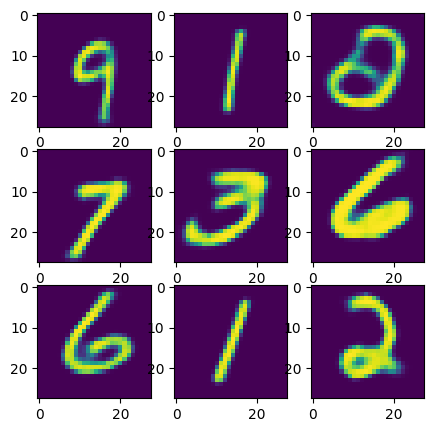

1875/1875 [==============================] - 3s 2ms/step


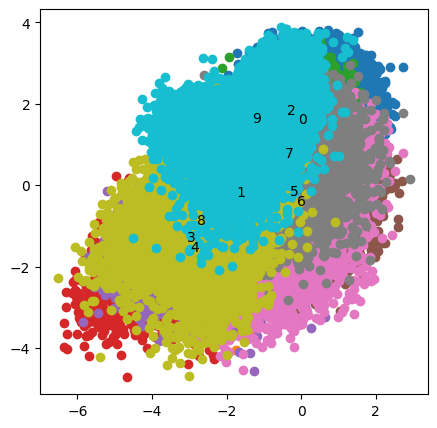

Cluster Validity Metrics (Autoencoder 1):
Silhouette Score: 0.1465596
Davies-Bouldin Index: 1.94880457792993
Calinski-Harabasz Index: 5628.6063602351915


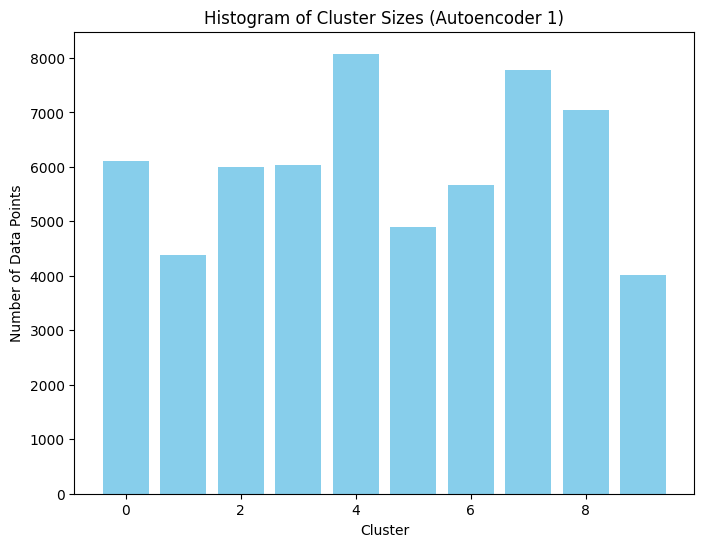

In [10]:
#Добавить класификатор, на вход которого подключен предобученный энкодер
# получаем выход автоэнкодера, изображения который он получает
index = numpy.random.randint(0,len(all_image),9)
out_img = autoencoder.predict(all_image[index])
# выводим их на графике
fig = plt.figure(figsize=(5,5))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3,3,i*3+j+1)
        ax.imshow(out_img[i*3+j][:,:,0])
plt.show()
# реализуем работу  с энкодером получая скрытый кодовый слой
out_vec = encoder.predict(all_image)
out_vec_save = out_vec;
# получим центроиды кластеров для 10 кластеров
centroid, label = kmeans2(out_vec, num_classes, minit='++')

# получим центроиды кластеров для 2 кластеров
centroid1, label1 = kmeans2(out_vec, 2, minit='++')

# считаем координаты кластера как разность с центроидом
out_vec1 = (out_vec - centroid1[0])**2
out_vec2 = (out_vec - centroid1[1])**2
# берем среднее значение
outm = out_vec1.mean(axis=1)
outstd = out_vec2.mean(axis=1)

coutm = centroid.mean(axis=1)
coutstd = centroid.mean(axis=1)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
# рисуем на графике кластер объектов в виде среднее дисперсия
for i in range(num_classes):
  mask = label == i
  ax.scatter(out_vec[mask,0],out_vec[mask,1])
  plt.text(centroid[i,0], centroid[i,1], i , fontdict=None)
plt.show()

# Compute silhouette score
silhouette = silhouette_score(out_vec, label)

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(out_vec, label)

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(out_vec, label)

# Print the cluster validity metrics
print('Cluster Validity Metrics (Autoencoder 1):')
print('Silhouette Score:', silhouette)
print('Davies-Bouldin Index:', davies_bouldin)
print('Calinski-Harabasz Index:', calinski_harabasz)

centroid, label = kmeans2(out_vec, num_classes, minit='++')

# Count the number of data points in each cluster
cluster_sizes = numpy.bincount(label)

# Plot a histogram of cluster sizes
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Histogram of Cluster Sizes (Autoencoder 1)')
plt.show()

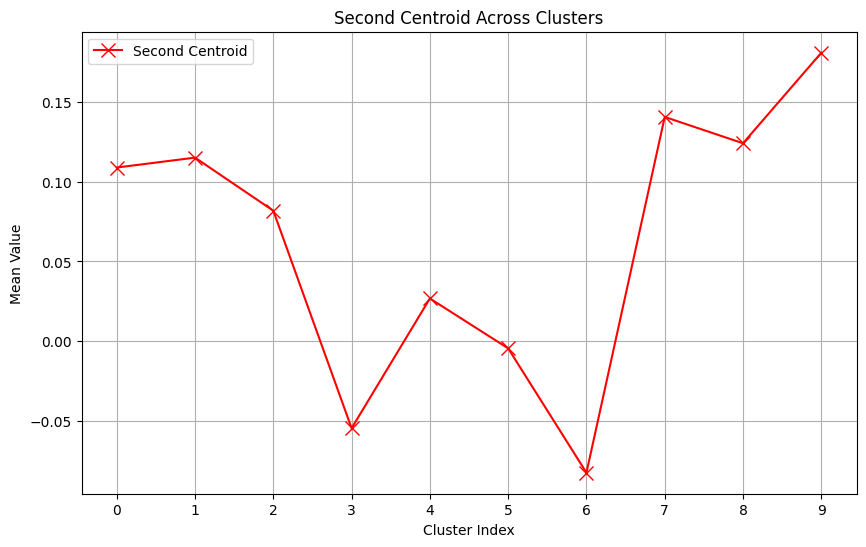

In [11]:
# Новый график
# Визуализация второй центроиды кластера

plt.figure(figsize=(10, 6))

# Рисуем линейчатый график для среднего значения второй центроиды по класстерам
plt.plot(range(len(coutm)), coutm, marker='x', color='red', markersize=10, label='Second Centroid')

plt.title('Second Centroid Across Clusters')
plt.xlabel('Cluster Index')
plt.ylabel('Mean Value')
plt.xticks(range(10))
plt.legend()
plt.grid(True)
plt.show()

In [12]:
latent_dim = 2
encoder = keras.models.load_model("encoder_vae.keras")
encoder.trainable = False

# Load MNIST train and test datasets
(trainx, trainy), (testx, testy) = mnist.load_data()
all_image_train = (trainx / 255.0 - 0.5) * 1.999
all_image_train = numpy.expand_dims(all_image_train, axis=3)

# Obtain latent representations using the encoder for train data
z_mean_train, z_log_var_train, z_train = encoder.predict(all_image_train)

# Preprocess test data
all_image_test = (testx / 255.0 - 0.5) * 1.999
all_image_test = numpy.expand_dims(all_image_test, axis=3)

# Obtain latent representations using the encoder for test data
z_mean_test, z_log_var_test, z_test = encoder.predict(all_image_test)

trainy_one_hot = keras.utils.to_categorical(trainy, num_classes=10)

313/313 [==============================] - 1s 2ms/step


In [13]:

trainy_one_hot = keras.utils.to_categorical(trainy, num_classes=10)

num_classes = 10
batch_size_t = 4000
n_count = 256
ep = 20
activation_func = 'relu'


latent_inputs = Input(shape=(latent_dim,))
x = Dense(n_count, activation='relu')(latent_inputs)
x = Dropout(0.5)(x)  # Dropout layer for regularization
classifier_output = Dense(10, activation='softmax')(x)
classifier_model = Model(latent_inputs, classifier_output)

# Compile classifier model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
classifier_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train classifier model
history = classifier_model.fit(z_train, trainy_one_hot, epochs=20, batch_size=batch_size_t, validation_split=0.1, callbacks=[early_stopping])
classifier_model.save('classifier_aev_history.keras')


Epoch 1/20
14/14 [==============================] - 1s 19ms/step - loss: 2.8170 - accuracy: 0.1143 - val_loss: 2.1884 - val_accuracy: 0.2118
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 2.4663 - accuracy: 0.1596 - val_loss: 2.0559 - val_accuracy: 0.2413
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 2.2836 - accuracy: 0.1891 - val_loss: 2.0036 - val_accuracy: 0.2362
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 2.1818 - accuracy: 0.2044 - val_loss: 1.9797 - val_accuracy: 0.2528
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 2.1185 - accuracy: 0.2140 - val_loss: 1.9646 - val_accuracy: 0.2553
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 2.0720 - accuracy: 0.2215 - val_loss: 1.9553 - val_accuracy: 0.2583
Epoch 7/20
14/14 [==============================] - 0s 6ms/step - loss: 2.0460 - accuracy: 0.2217 - val_loss: 1.9476 - val_accuracy: 0.2585
Epoch 8/20
14/14 [=

In [14]:
test_loss, test_accuracy = classifier_model.evaluate(z_test, keras.utils.to_categorical(testy, num_classes=10))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 1.8168 - accuracy: 0.3249
Test Loss: 1.8168
Test Accuracy: 0.3249


In [15]:
encoder = krs.models.load_model('encoder_model.keras')
encoder.trainable = False

(trainx, trainy), (testx, testy) = mnist.load_data()
all_image = (trainx/255.0-0.5)*1.999
# добавляем дополнительное измерение соответствующее одной цветовой карте
all_image = numpy.expand_dims(all_image, axis=3)

out_vec_save = encoder.predict(all_image)
all_out = krs.utils.to_categorical(trainy)

1875/1875 [==============================] - 3s 2ms/step


In [16]:
all_out = krs.utils.to_categorical(trainy)
num_classes = 10
num_hide = 98
batch_size_t = 128
n_count = 128
ep = 20
activation_func = 'relu'

# Define classifier model
classifier_input = Input(shape=(num_hide,))
x = Dense(n_count, activation='relu')(classifier_input)
x = Dropout(0.5)(x)  # Dropout layer for regularization
classifier_output = Dense(num_classes, activation='softmax')(x)
classifier_model = Model(classifier_input, classifier_output)

# Compile classifier model with a lower learning rate
optimizer = Adam(learning_rate=0.001)  # Use 'learning_rate' instead of 'lr'
classifier_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train classifier model with data augmentation and early stopping
history = classifier_model.fit(out_vec_save, all_out, epochs=ep, batch_size=batch_size_t, validation_split=0.1, callbacks=[early_stopping])
classifier_model.save('classifier_history.keras')

Epoch 1/20
422/422 [==============================] - 2s 4ms/step - loss: 0.6194 - accuracy: 0.8070 - val_loss: 0.1905 - val_accuracy: 0.9490
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3074 - accuracy: 0.9064 - val_loss: 0.1428 - val_accuracy: 0.9610
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2555 - accuracy: 0.9238 - val_loss: 0.1247 - val_accuracy: 0.9667
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2280 - accuracy: 0.9301 - val_loss: 0.1090 - val_accuracy: 0.9705
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.2115 - accuracy: 0.9353 - val_loss: 0.0999 - val_accuracy: 0.9717
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.1983 - accuracy: 0.9389 - val_loss: 0.0955 - val_accuracy: 0.9730
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.1880 - accuracy: 0.9429 - val_loss: 0.0941 - val_accuracy: 0.9738
Epoch 

In [17]:
# Evaluate classifier model
test_image = (testx / 255.0 - 0.5) * 1.999
test_image = numpy.expand_dims(test_image, axis=3)
test_out_vec = encoder.predict(test_image)
test_out = krs.utils.to_categorical(testy)
accuracy = classifier_model.evaluate(test_out_vec, test_out)
print('Test Accuracy:', accuracy[1])
y_pred_proba = classifier_model.predict(test_out_vec)

313/313 [==============================] - 1s 2ms/step - loss: 0.0813 - accuracy: 0.9738
Test Accuracy: 0.973800003528595
313/313 [==============================] - 1s 2ms/step


In [18]:
all_out = krs.utils.to_categorical(trainy)
num_classes = 10
num_hide = 98
n_count = 128
dropout= 0.2
ep = 80
activation_func = 'relu'

classifier_input = krs.layers.Input(shape=(num_hide,))
encoder.trainable = False

lay = krs.layers.Dense(n_count, activation=activation_func)(classifier_input)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 2, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 4, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count * 2, activation=activation_func)(lay)
lay = krs.layers.Dropout(dropout)(lay)
lay = krs.layers.Dense(n_count, activation=activation_func)(lay)
lay = krs.layers.BatchNormalization()(lay)
lay = krs.layers.Dense(num_classes, activation=activation_func, kernel_initializer='random_uniform')(lay)
classifier_output = krs.layers.Dense(num_classes, activation='tanh', name='den4')(lay)

print('Shape of classifier_output:', classifier_output.shape)
classificator = krs.Model(classifier_input, classifier_output)
classificator.compile(loss='binary_crossentropy', optimizer=krs.optimizers.Adam(learning_rate = 0.001),
                      metrics=['accuracy', krs.metrics.Precision(), krs.metrics.Recall()])
classificator.fit(x = out_vec_save, y = all_out, batch_size = 8000 ,epochs = ep)

test_out_vec = encoder.predict(numpy.expand_dims((testx/255.0-0.5)*1.999, axis=3))
y_pred_proba = classifier_model.predict(test_out_vec)
predictions = classificator.predict(test_out_vec)
classificator.save('classificator_model.keras')

Shape of classifier_output: (None, 10)
Epoch 1/80
8/8 [==============================] - 4s 17ms/step - loss: 0.8650 - accuracy: 0.1580 - precision_1: 0.2749 - recall_1: 0.0105
Epoch 2/80
8/8 [==============================] - 0s 15ms/step - loss: 0.6475 - accuracy: 0.2273 - precision_1: 0.3359 - recall_1: 0.0421
Epoch 3/80
8/8 [==============================] - 0s 13ms/step - loss: 0.5558 - accuracy: 0.2523 - precision_1: 0.3193 - recall_1: 0.0623
Epoch 4/80
8/8 [==============================] - 0s 12ms/step - loss: 0.4785 - accuracy: 0.2875 - precision_1: 0.3483 - recall_1: 0.0888
Epoch 5/80
8/8 [==============================] - 0s 12ms/step - loss: 0.4174 - accuracy: 0.3332 - precision_1: 0.3990 - recall_1: 0.1363
Epoch 6/80
8/8 [==============================] - 0s 12ms/step - loss: 0.3865 - accuracy: 0.3562 - precision_1: 0.4271 - recall_1: 0.1554
Epoch 7/80
8/8 [==============================] - 0s 14ms/step - loss: 0.3616 - accuracy: 0.3845 - precision_1: 0.4720 - recall_1: 0.

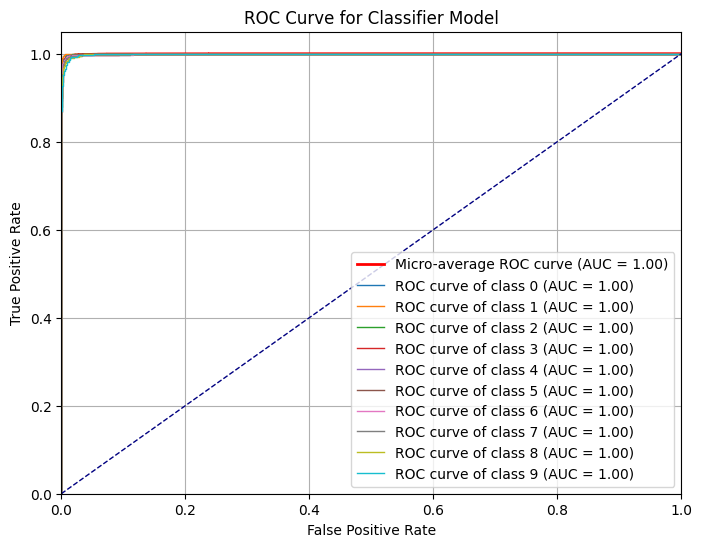

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # Assuming you have 10 classes
    fpr[i], tpr[i], _ = roc_curve(test_out[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(test_out.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_micro))
for i in range(10):  # Assuming you have 10 classes
    plt.plot(fpr[i], tpr[i], lw=1, label='ROC curve of class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifier Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Epoch 1/5
469/469 [==============================] - 5s 6ms/step - loss: 0.2173 - accuracy: 0.9364 - val_loss: 0.0662 - val_accuracy: 0.9796
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0624 - accuracy: 0.9811 - val_loss: 0.0431 - val_accuracy: 0.9849
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0421 - accuracy: 0.9873 - val_loss: 0.0400 - val_accuracy: 0.9871
Epoch 4/5
469/469 [==============================] - 3s 5ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9882
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0405 - accuracy: 0.9880


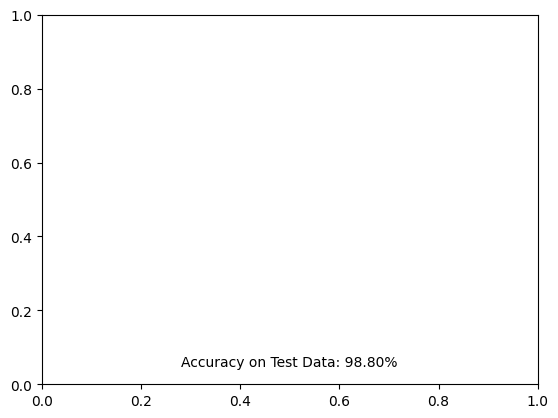

In [22]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess data
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
num_classes = 10
y_train = numpy.eye(num_classes)[y_train]
y_test = numpy.eye(num_classes)[y_test]

# Build CNN model
model = krs.Sequential()
model.add(krs.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(krs.layers.MaxPooling2D((2, 2)))
model.add(krs.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(krs.layers.MaxPooling2D((2, 2)))
model.add(krs.layers.Flatten())
model.add(krs.layers.Dense(128, activation='relu'))
model.add(krs.layers.Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test), verbose=1)

# Predict probabilities
y_pred_proba = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test)
plt.text(0.5, 0.05, 'Accuracy on Test Data: {:.2f}%'.format(accuracy*100), ha='center')
plt.show()

In [23]:
out_img_predict = classificator.predict(out_vec_save)
numer_out = 0
for i in range(17):
  for j in range(10):
    if all_out[i][j] == 1:
      numer_out = j
  print(out_img_predict[i][numer_out], 9 - numer_out)
  # print(out_img_predict[i], all_out[i])

1875/1875 [==============================] - 3s 2ms/step
0.76633936 4
0.93294656 9
0.36812848 5
0.89981204 8
0.6941314 0
0.5971942 7
0.9638375 8
0.81291467 6
0.96959704 8
0.4920743 5
0.8469502 6
0.8317848 4
0.93009734 6
0.89272493 3
0.9833885 8
0.9247917 2
0.6844245 7


In [24]:
out_img_predict = classificator.predict(out_vec_save)
for i in range(17):
  print(out_img_predict[i], all_out[i])

1875/1875 [==============================] - 3s 2ms/step
[-0.60332507 -0.18885866 -0.51425254  0.40805337 -0.8778338   0.76633936
 -0.73959774 -0.86034805 -0.32612994 -0.69029135] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[ 0.93294656 -0.84165597 -0.01681573 -0.4436393  -0.06993745  0.08361357
 -0.30416813 -0.6302376  -0.03930328 -0.13017078] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.4672848  -0.25208792 -0.41478586 -0.5844929   0.36812848 -0.3853414
 -0.27929893  0.06758131 -0.01519367  0.6990801 ] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[-0.8045285   0.89981204 -0.4571846  -0.2306428  -0.8490273  -0.60266703
 -0.18842967 -0.36412388 -0.19508575 -0.85640115] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.39043656 -0.30770674 -0.54740256 -0.55811405  0.31739345 -0.28931817
 -0.2700949   0.00394525 -0.10311935  0.6941314 ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[-0.43157735 -0.10577457  0.5971942  -0.2441645  -0.0810371  -0.7316183
 -0.39958495  0.21870221  0.1807975   0.08065436] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[-0.82360965  0